# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import os
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 2. Define the Architecture of the Policy

In [63]:
env = gym.make('CartPole-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

USE_GPU = 0
if USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import tensorflow as tf
    
class Policy():
    def __init__(self, s_size=4, h_size=16, a_size=2):
        self.s_size = s_size
        self.h_size = h_size
        self.a_size = a_size
        
        self._build_network()
        print("Build model done")
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        
    def _build_network(self):
        ##
        self.inputs = tf.placeholder(shape = (None, self.s_size), dtype=tf.float32)
        self.taken_actions = tf.placeholder(shape = (None, ), dtype = tf.int32)
        self.discount_rewards = tf.placeholder(shape = (None,), dtype= tf.float32)
        ##
        actions = tf.one_hot(self.taken_actions, depth=self.a_size)
        x = tf.layers.dense(self.inputs, units=self.h_size, activation=tf.nn.relu)
        self.output = tf.layers.dense(x, units=self.a_size)
        self.soft_out = tf.nn.softmax(self.output)
        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.output,
                                                                              labels=actions))
        
        optimizer = tf.train.AdamOptimizer(learning_rate = 1e-2)
        self.gradient = optimizer.compute_gradients(self.loss)
        for i, (grad, var) in enumerate(self.gradient):
            if grad is not None:
                """
                Remember to multiply with -1, because we are doing gradient ascent
                Hence, gradient for descending is 0 ~ inf, we multiply -1 to make it -inf ~ 0
                """
                self.gradient[i] = (grad * self.discount_rewards[i] * tf.constant([-1.]), var)
        
        self.train_op = optimizer.apply_gradients(self.gradient)
        
    def train(self, states, actions, rewards):
        self.sess.run([self.train_op], feed_dict = {self.inputs: states,
                                                    self.taken_actions: actions,
                                                    self.discount_rewards: rewards})
    
    def act(self, states):
        states = states.ravel()[np.newaxis, :]
        probs = self.sess.run(self.soft_out, feed_dict = {self.inputs: states})[0]
        action = np.random.choice(np.arange(self.a_size), p=probs)
        # return selected action and its prob
        return action

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [64]:
tf.reset_default_graph()
policy = Policy()

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_states = []
        saved_actions = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action = policy.act(state)
            saved_states.append(state)
            saved_actions.append(action)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        # get rewards for each action in the episose multiply by discount factor
        R = [a*b for a,b in zip(discounts, rewards)]
        policy.train(states=np.array(saved_states, dtype=np.float32), 
                     actions=np.array(saved_actions, dtype=np.int32), 
                     rewards=np.array(R, dtype=np.float32))
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Build model done
Episode 100	Average Score: 22.13
Episode 200	Average Score: 39.11
Episode 300	Average Score: 61.53
Episode 400	Average Score: 103.11
Episode 500	Average Score: 128.73
Episode 600	Average Score: 156.50
Environment solved in 576 episodes!	Average Score: 195.13


### 4. Plot the Scores

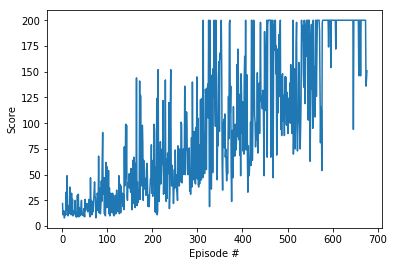

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

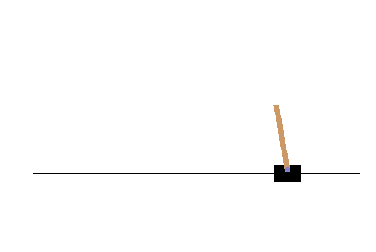

In [66]:
env = gym.make('CartPole-v0')

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(1000):
    action = policy.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()